In [31]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Import required libraries 
import re
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model

from keras import optimizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [33]:
# Set directory path
import os
os.chdir("/content/drive/My Drive/Assignment 3/DS")

In [34]:
# Define function to get data
def get_data(data_class, class_label):

  # Create an empty array to add data of images
  data = []

  # Get list of images in current directory
  for img in os.listdir('.'):

    # Match the file name with class label
    if re.match(data_class, img):

      print(img)

      # Read image and add it to the array
      img_arr = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

      # Resize an image to the size of 32x32
      resized_arr = cv2.resize(img_arr, (32, 32))

      # Append resized image and class label to the array
      data.append([resized_arr, class_label])
      
  return np.array(data)

In [35]:
# Get the data by class labels
dataset_abdomen = get_data('Abdomen', 0)
dataset_chest = get_data('Chest', 1)
dataset_head = get_data('Head', 2)

Abdomen_CT Sample#428.jpeg
Abdomen_CT Sample#397.jpeg
Abdomen_CT Sample#398.jpeg
Abdomen_CT Sample#137.jpeg
Abdomen_CT Sample#329.jpeg
Abdomen_CT Sample#55.jpeg
Abdomen_CT Sample#72.jpeg
Abdomen_CT Sample#486.jpeg
Abdomen_CT Sample#196.jpeg
Abdomen_CT Sample#228.jpeg
Abdomen_CT Sample#204.jpeg
Abdomen_CT Sample#232.jpeg
Abdomen_CT Sample#220.jpeg
Abdomen_CT Sample#381.jpeg
Abdomen_CT Sample#413.jpeg
Abdomen_CT Sample#291.jpeg
Abdomen_CT Sample#372.jpeg
Abdomen_CT Sample#166.jpeg
Abdomen_CT Sample#113.jpeg
Abdomen_CT Sample#174.jpeg
Abdomen_CT Sample#90.jpeg
Abdomen_CT Sample#429.jpeg
Abdomen_CT Sample#251.jpeg
Abdomen_CT Sample#263.jpeg
Abdomen_CT Sample#495.jpeg
Abdomen_CT Sample#54.jpeg
Abdomen_CT Sample#117.jpeg
Abdomen_CT Sample#138.jpeg
Abdomen_CT Sample#377.jpeg
Abdomen_CT Sample#452.jpeg
Abdomen_CT Sample#351.jpeg
Abdomen_CT Sample#328.jpeg
Abdomen_CT Sample#94.jpeg
Abdomen_CT Sample#239.jpeg
Abdomen_CT Sample#87.jpeg
Abdomen_CT Sample#440.jpeg
Abdomen_CT Sample#127.jpeg
Abdomen

In [36]:
# Merge the data with all the class labels
dataset = []
dataset.append(dataset_abdomen)
dataset.append(dataset_chest)
dataset.append(dataset_head)
dataset = np.array(dataset)

In [37]:
# Reshape the data into two-dimentional numpy array in order to process it to algorithms
dataset_final = dataset.reshape(1500,2)

In [38]:
# Get features in X and class label in y from the data
X = []
y = []

for feature, label in dataset_final:
  X.append(feature)
  y.append(label)

In [39]:
# Split the data into test and train set
# 70% trainig set and 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

In [40]:
# Normalize the data
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255

In [41]:
# # Resize data for deep learning 
img_size = 32
X_Train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_Test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [42]:
# Data Augmentation is done to deal with overfitting
data_aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

data_aug.fit(X_Train)

In [43]:
# Define activation function
activationFunction='relu'

# Define function for Convolutional Neural Network model
def get_cnn_model():

  # Add layers to the model
  model = Sequential()

  # Add convolution layers
  model.add(Conv2D(128, kernel_size = (5, 5), activation=activationFunction, input_shape=(32, 32, 1)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, kernel_size=(4, 4), activation=activationFunction))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(32, kernel_size=(3, 3), activation=activationFunction))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Add flatten layer
  model.add(Flatten())

  # Add dense layers
  model.add(Dense(128, activation=activationFunction))
  model.add(Dense(64, activation=activationFunction))
  model.add(Dense(32, activation=activationFunction))
  model.add(Dense(16, activation=activationFunction))

  # Define dense layer as feature_layer to extract features later
  model.add(Dense(8, activation=activationFunction, name='feature_layer'))
  
  model.add(Dense(3, activation = 'softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [44]:
# # Define the model
model = get_cnn_model()

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        131136    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 32)          18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)               

In [46]:
# Fit the model on augmented data
early_stops = EarlyStopping(patience=5, monitor='accuracy')
filepath = '/content/drive/My Drive/Assignment 3'
ckpt_callback = ModelCheckpoint(filepath,
                                 monitor='loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model.fit_generator(data_aug.flow(X_Train, y_train),
          # validation_data = (X_Test, y_test),
          # callbacks=[early_stops,ckpt_callback],
          # batch_size = 64,
           epochs= 20)

Epoch 1/20
33/33 [==============================] - 0s 12ms/step - loss: 0.9983 - accuracy: 0.4343
Epoch 2/20
33/33 [==============================] - 0s 12ms/step - loss: 0.6340 - accuracy: 0.5648
Epoch 3/20
33/33 [==============================] - 0s 13ms/step - loss: 0.4159 - accuracy: 0.8714
Epoch 4/20
33/33 [==============================] - 0s 12ms/step - loss: 0.1485 - accuracy: 0.9533
Epoch 5/20
33/33 [==============================] - 0s 12ms/step - loss: 0.0399 - accuracy: 0.9886
Epoch 6/20
33/33 [==============================] - 0s 12ms/step - loss: 0.4035 - accuracy: 0.8771
Epoch 7/20
33/33 [==============================] - 0s 12ms/step - loss: 0.0627 - accuracy: 0.9876
Epoch 8/20
33/33 [==============================] - 0s 12ms/step - loss: 0.0908 - accuracy: 0.9648
Epoch 9/20
33/33 [==============================] - 0s 12ms/step - loss: 0.0501 - accuracy: 0.9867
Epoch 10/20
33/33 [==============================] - 0s 12ms/step - loss: 0.0139 - accuracy: 0.9962
Epoch 11/

In [47]:
# Change directory to store models
os.chdir("/content/drive/My Drive/Assignment 3")

In [48]:
# Save CNN model
model.save('1095526_CNN.h5')

In [49]:
# Define a new model that use CNN model to extract features by using feature_layer defined earlier
loaded_model = load_model('1095526_CNN.h5')
new_model = keras.Model(inputs = loaded_model.input, outputs = loaded_model.get_layer('feature_layer').output)
new_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        131136    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 32)          18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 32)         

In [50]:
# Get new train and test set with extracted features
train_x = new_model.predict(data_aug.flow(X_Train, y_train))
test_x = new_model.predict(X_test)

In [51]:
# Define parameters for K-Nearest Neighbor algorithm
grid_params = {
    'n_neighbors' : [3, 5, 7, 9]
    }

knn = KNeighborsClassifier()

# Use grid search to find best parameter for KNN classifier
knn_gs = GridSearchCV(
    knn,
    grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1)

# Fit KNN model on training data
knn_gs.fit(train_x, y_train)

# Prints best parameters for KNN
print("Best Parameter for KNN is: " + str(knn_gs.best_params_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Parameter for KNN is: {'n_neighbors': 5}


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.0s finished


In [52]:
# Results for each folds
knn_gs.cv_results_

{'mean_fit_time': array([0.00201432, 0.00279506, 0.00214656, 0.00141525]),
 'mean_score_time': array([0.01975791, 0.01931294, 0.02129817, 0.01991781]),
 'mean_test_score': array([0.32952381, 0.34      , 0.33333333, 0.33619048]),
 'param_n_neighbors': masked_array(data=[3, 5, 7, 9],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 7},
  {'n_neighbors': 9}],
 'rank_test_score': array([4, 1, 3, 2], dtype=int32),
 'split0_test_score': array([0.3       , 0.33714286, 0.32571429, 0.32571429]),
 'split1_test_score': array([0.32857143, 0.32285714, 0.34571429, 0.33428571]),
 'split2_test_score': array([0.36      , 0.36      , 0.32857143, 0.34857143]),
 'std_fit_time': array([4.17216997e-04, 2.60275739e-05, 1.01282634e-03, 6.64861604e-05]),
 'std_score_time': array([0.00121056, 0.00115171, 0.00078454, 0.00340861]),
 'std_test_score': array([0.02450415, 0.0152975 , 0.00883202

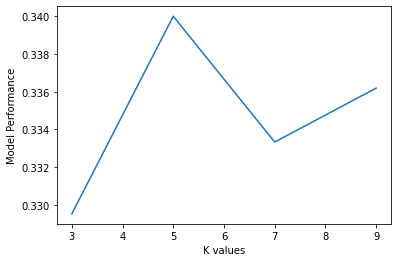

In [53]:
# Plot the graph for different k values and performance of the model
scores = knn_gs.cv_results_['mean_test_score']
plt.plot(grid_params['n_neighbors'], scores)
plt.xlabel('K values')
plt.ylabel('Model Performance')
plt.show()

In [54]:
# Save model to the current directory
pickle.dump(knn_gs, open('1095526_KNN.pkl', 'wb'))

In [55]:
# Load the saved model
loaded_model_knn = pickle.load(open('1095526_KNN.pkl', 'rb'))

# Use loaded model to predict values for test set
y_pred = loaded_model_knn.predict(test_x)
print("Confusion Metrix for KNN")
print(confusion_matrix(y_test, y_pred))
print("\nModel Performance for KNN")
print(classification_report(y_test, y_pred))

Confusion Metrix for KNN
[[76 52 20]
 [82 32 27]
 [70 57 34]]

Model Performance for KNN
              precision    recall  f1-score   support

           0       0.33      0.51      0.40       148
           1       0.23      0.23      0.23       141
           2       0.42      0.21      0.28       161

    accuracy                           0.32       450
   macro avg       0.33      0.32      0.30       450
weighted avg       0.33      0.32      0.30       450



In [56]:
# Define parameter values for hyperparaeter tuning of Random Forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap
               }

In [57]:
# Define Random Forest Classifier as we have to predict classes
rf = RandomForestClassifier()

# Define random search to get best values to select parameters randomly as takes more time
rf_tune = RandomizedSearchCV(
    rf,
    random_grid,
    cv = 3,
    verbose = 1,
    n_jobs = -1)

# Fit Random Forest on training data
rf_tune.fit(train_x, y_train)

# Print best parameters for random forest
print("Best Parameters for Random Forest are: " + str(rf_tune.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   52.7s finished


Best Parameters for Random Forest are: {'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}


In [58]:
# Results for each folds
rf_tune.cv_results_

{'mean_fit_time': array([3.46072841, 3.7035447 , 0.63339233, 1.26619458, 1.25980306,
        6.19342772, 3.96716706, 3.18177025, 5.73685455, 3.26334325]),
 'mean_score_time': array([0.23437619, 0.2364556 , 0.04678861, 0.09248416, 0.09182191,
        0.45122313, 0.26913023, 0.22592775, 0.40654683, 0.2301867 ]),
 'mean_test_score': array([0.35238095, 0.36      , 0.35714286, 0.36      , 0.35809524,
        0.36      , 0.35904762, 0.35142857, 0.35333333, 0.35428571]),
 'param_bootstrap': masked_array(data=[True, False, True, True, True, False, False, True,
                    True, True],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 50, 80, 60, 90, 60, 20, 70, 90, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 

In [59]:
# Save model to the current directory
pickle.dump(rf_tune, open('1095526_RF.pkl', 'wb'))

In [60]:
# Load the saved model
loaded_model_rf = pickle.load(open('1095526_RF.pkl', 'rb'))

# Use loaded model to predict values for test set
y_pred = loaded_model_rf.predict(test_x)
print("Confusion Metrix for Random Forest")
print(confusion_matrix(y_test, y_pred))
print("\nModel Performance for Random Forest")
print(classification_report(y_test, y_pred))

Confusion Metrix for Random Forest
[[54 55 39]
 [60 36 45]
 [43 50 68]]

Model Performance for Random Forest
              precision    recall  f1-score   support

           0       0.34      0.36      0.35       148
           1       0.26      0.26      0.26       141
           2       0.45      0.42      0.43       161

    accuracy                           0.35       450
   macro avg       0.35      0.35      0.35       450
weighted avg       0.35      0.35      0.35       450

